In [109]:
# imports
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline
from ipywidgets import interact, IntSlider

In [124]:
# set up environment
dim = 2
grid_size = {'x': 20, 'y': 20} # to start out
domain_size = {'x': 20, 'y': 20} # to start out

# boundary_condition
# constant boundary condition
bc_left = 0
bc_right = 0
bc_top = 0
bc_bottom = 0

delta_x = domain_size['x'] / grid_size['x']
delta_y = domain_size['y'] / grid_size['y'] 

alpha_x = np.random.random((grid_size['x'],grid_size['y']))
alpha_y = np.ones((grid_size['x'],grid_size['y']))

# time dimension
max_stable_time_step_x = delta_x**2 / (2 * np.max(alpha_x))
max_stable_time_step_y = delta_y**2 / (2 * np.max(alpha_y))
max_stable_time_step = max_stable_time_step_x if max_stable_time_step_x <= max_stable_time_step_y else max_stable_time_step_y

time_step = 0.1
if time_step > max_stable_time_step:
    print('Warning: Time step more than maximum stable time step!')

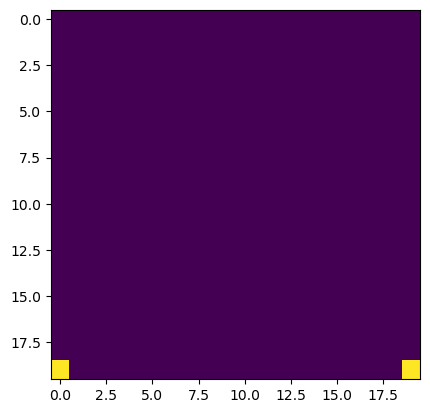

In [125]:
# initialize environment with start values
C_t = np.zeros((grid_size['x'],grid_size['y']))
C_t[19,0] = 2000
C_t[19,19] = 2000


plt.imshow(C_t, vmin=0, vmax=2000)
plt.show()

In [114]:
# calculate mean between two cells
def alpha_interblock(alpha1, alpha2, harmonic=False):
    if not harmonic:
        return 0.5 * (alpha1 + alpha2)
    else:
        return 2 / ((1/alpha1) + (1/alpha2))


### Implementation for constant boundary conditions

In [31]:
# simulate one time step
def simulate_constant_boundary(C_t): 
        C_t1 = np.zeros((grid_size['x'],grid_size['y']))

        # inner cells
        for i in range(1, grid_size['y']-1): #rows
                for j in range(1, grid_size['x']-1): #columns
                        C_t1[i,j] = C_t[i,j] \
                                + time_step/delta_y**2 * (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) * C_t[i+1,j]
                                        - (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) 
                                        + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j]) * C_t[i-1,j]) \
                                + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * C_t[i,j+1]
                                        - (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) 
                                        + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j]) * C_t[i,j-1])
                        
        # boundary conditions
        # left without corners / looping over rows
        for i in range(1, grid_size['y']-1):
               j = 0
               C_t1[i,0] = C_t[i,0] \
                        + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * C_t[i,j+1] 
                                - (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) + 2 * alpha_x[i,j]) * C_t[i,j]
                                + 2 * alpha_x[i,j] * bc_left) \
                        + time_step/delta_y**2 * (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) * C_t[i+1,j]
                                        - (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) 
                                        + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j]) * C_t[i-1,j])        

        # right without corners / looping over rows
        n = grid_size['x']-1 # maximum index in x-direction (columns)
        for i in range(1, grid_size['y']-1):
               j = n
               C_t1[i,n] = C_t[i,n] \
                        + time_step/delta_x**2 * (2 * alpha_x[i,n] * bc_right 
                                - (alpha_interblock(alpha_x[i,n-1], alpha_x[i,n]) + 2 * alpha_x[i,n]) * C_t[i,n]
                                + alpha_interblock(alpha_x[i,n-1], alpha_x[i,n]) * C_t[i,n-1]) \
                        + time_step/delta_y**2 * (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) * C_t[i+1,j]
                                        - (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) 
                                        + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j]) * C_t[i-1,j])

        # top without corners / looping over columns
        for j in range(1, grid_size['x']-1):
               i = 0
               C_t1[0,j] = C_t[0,j] \
                        + time_step/delta_y**2 * (alpha_interblock(alpha_y[1,j], alpha_y[0,j]) * C_t[1,j] 
                                - (alpha_interblock(alpha_y[1,j], alpha_y[0,j]) + 2 * alpha_y[0,j]) * C_t[0,j]
                                + 2 * alpha_y[0,j] * bc_top) \
                        + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * C_t[i,j+1]
                                        - (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) 
                                        + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j]) * C_t[i,j-1])

        # bottom without corners / looping over columns
        m = grid_size['y']-1 # maximum index in y-direction (rows)
        for j in range(1, grid_size['x']-1):
               i = m
               C_t1[m,j] = C_t[m,j] \
                        + time_step/delta_y**2 * (2 * alpha_y[m,j] * bc_bottom 
                                - (alpha_interblock(alpha_y[m,j], alpha_y[m-1,j]) + 2 * alpha_y[m,j]) * C_t[m,j]
                                + alpha_interblock(alpha_y[m,j], alpha_y[m-1,j]) * C_t[m-1,j]) \
                        + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * C_t[i,j+1]
                                        - (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) 
                                        + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j]) * C_t[i,j-1])

        # corner top left
        i = 0
        j = i
        C_t1[i,j] = C_t[i,j] \
                        + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * C_t[i,j+1] 
                                - (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) + 2 * alpha_x[i,j]) * C_t[i,j]
                                + 2 * alpha_x[i,j] * bc_left) \
                        + time_step/delta_y**2 * (alpha_interblock(alpha_y[1,j], alpha_y[0,j]) * C_t[1,j] 
                                - (alpha_interblock(alpha_y[1,j], alpha_y[0,j]) + 2 * alpha_y[0,j]) * C_t[0,j]
                                + 2 * alpha_y[0,j] * bc_top)
                        

        # corner top right
        i = 0
        j = grid_size['x']-1
        n = j
        C_t1[i,j] = C_t[i,j] \
                        + time_step/delta_x**2 * (2 * alpha_x[i,n] * bc_right 
                                - (alpha_interblock(alpha_x[i,n-1], alpha_x[i,n]) + 2 * alpha_x[i,n]) * C_t[i,n]
                                + alpha_interblock(alpha_x[i,n-1], alpha_x[i,n]) * C_t[i,n-1]) \
                        + time_step/delta_y**2 * (alpha_interblock(alpha_y[1,j], alpha_y[0,j]) * C_t[1,j] 
                                - (alpha_interblock(alpha_y[1,j], alpha_y[0,j]) + 2 * alpha_y[0,j]) * C_t[0,j]
                                + 2 * alpha_y[0,j] * bc_top)

        # corner bottom left
        i = grid_size['y']-1
        m = i
        j = 0
        C_t1[i,j] = C_t[i,j] \
                        + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * C_t[i,j+1] 
                                - (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) + 2 * alpha_x[i,j]) * C_t[i,j]
                                + 2 * alpha_x[i,j] * bc_left) \
                        + time_step/delta_y**2 * (2 * alpha_y[m,j] * bc_bottom 
                                - (alpha_interblock(alpha_y[m,j], alpha_y[m-1,j]) + 2 * alpha_y[m,j]) * C_t[m,j]
                                + alpha_interblock(alpha_y[m,j], alpha_y[m-1,j]) * C_t[m-1,j])

        # corner bottom right
        i = grid_size['y']-1
        j = grid_size['x']-1
        m = i 
        n = j
        C_t1[i,j] = C_t[i,j] \
                        + time_step/delta_x**2 * (2 * alpha_x[i,n] * bc_right 
                                - (alpha_interblock(alpha_x[i,n-1], alpha_x[i,n]) + 2 * alpha_x[i,n]) * C_t[i,n]
                                + alpha_interblock(alpha_x[i,n-1], alpha_x[i,n]) * C_t[i,n-1]) \
                        + time_step/delta_y**2 * (2 * alpha_y[m,j] * bc_bottom 
                                - (alpha_interblock(alpha_y[m,j], alpha_y[m-1,j]) + 2 * alpha_y[m,j]) * C_t[m,j]
                                + alpha_interblock(alpha_y[m,j], alpha_y[m-1,j]) * C_t[m-1,j])

        return C_t1

### Implementation for closed boundary conditions

In [115]:
# simulate one time step
def simulate_closed_boundary(C_t): 
        C_t1 = np.zeros((grid_size['x'],grid_size['y']))

        # inner cells
        for i in range(1, grid_size['y']-1): #rows
                for j in range(1, grid_size['x']-1): #columns
                        C_t1[i,j] = C_t[i,j] \
                                + time_step/delta_y**2 * (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) * C_t[i+1,j]
                                        - (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j]) * C_t[i-1,j]) \
                                + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * C_t[i,j+1]
                                        - (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j]) * C_t[i,j-1])
                        
         # boundary conditions
        # left without corners / looping over rows
        for i in range(1, grid_size['y']-1):
               j = 0
               C_t1[i,0] = C_t[i,0] \
                        + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * (C_t[i,j+1] - C_t[i,j]))\
                        + time_step/delta_y**2 * (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) * C_t[i+1,j]
                                        - (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j]) * C_t[i-1,j])        

        # right without corners / looping over rows
        n = grid_size['x']-1 # maximum index in x-direction (columns)
        for i in range(1, grid_size['y']-1):
               j = n
               C_t1[i,n] = C_t[i,n] \
                        + time_step/delta_x**2 * ( 
                                - (alpha_interblock(alpha_x[i,n-1], alpha_x[i,n]) * (C_t[i,n] - C_t[i,n-1])))\
                        + time_step/delta_y**2 * (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) * C_t[i+1,j]
                                        - (alpha_interblock(alpha_y[i+1,j], alpha_y[i,j]) + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_y[i-1,j], alpha_y[i,j]) * C_t[i-1,j])

        # top without corners / looping over columns
        for j in range(1, grid_size['x']-1):
               i = 0
               C_t1[0,j] = C_t[0,j] \
                        + time_step/delta_y**2 * (alpha_interblock(alpha_y[1,j], alpha_y[0,j]) * (C_t[1,j] - C_t[0,j])) \
                        + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * C_t[i,j+1]
                                        - (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j]) * C_t[i,j-1])

        # bottom without corners / looping over columns
        m = grid_size['y']-1 # maximum index in y-direction (rows)
        for j in range(1, grid_size['x']-1):
               i = m
               C_t1[m,j] = C_t[m,j] \
                        + time_step/delta_y**2 * ( 
                                - (alpha_interblock(alpha_y[m,j], alpha_y[m-1,j]) * (C_t[m,j] - C_t[m-1,j]))) \
                        + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * C_t[i,j+1]
                                        - (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j])) * C_t[i,j] 
                                        + alpha_interblock(alpha_x[i,j-1], alpha_x[i,j]) * C_t[i,j-1])

        # corner top left
        i = 0
        j = i
        C_t1[i,j] = C_t[i,j] \
                        + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * (C_t[i,j+1] - C_t[i,j]))\
                        + time_step/delta_y**2 * (alpha_interblock(alpha_y[1,j], alpha_y[0,j]) * (C_t[1,j]-C_t[0,j]))
                        

        # corner top right
        i = 0
        j = grid_size['x']-1
        n = j
        C_t1[i,j] = C_t[i,j] \
                        + time_step/delta_x**2 * (- (alpha_interblock(alpha_x[i,n-1], alpha_x[i,n]) * (C_t[i,n] - C_t[i,n-1])))\
                        + time_step/delta_y**2 * (alpha_interblock(alpha_y[1,j], alpha_y[0,j]) * (C_t[1,j] - C_t[0,j])) 
        

        # corner bottom left
        i = grid_size['y']-1
        m = i
        j = 0
        C_t1[i,j] = C_t[i,j] \
                        + time_step/delta_x**2 * (alpha_interblock(alpha_x[i,j+1], alpha_x[i,j]) * (C_t[i,j+1] - C_t[i,j])) \
                        + time_step/delta_y**2 * (- (alpha_interblock(alpha_y[m,j], alpha_y[m-1,j] * (C_t[m,j] - C_t[m-1,j]))))

        # corner bottom right
        i = grid_size['y']-1
        j = grid_size['x']-1
        m = i 
        n = j
        C_t1[i,j] = C_t[i,j] \
                        + time_step/delta_x**2 * (- alpha_interblock(alpha_x[i,n-1], alpha_x[i,n]) * (C_t[i,n] - C_t[i,n-1]))\
                        + time_step/delta_y**2 * (- alpha_interblock(alpha_y[m,j], alpha_y[m-1,j] * (C_t[m,j] - C_t[m-1,j])))

        return C_t1

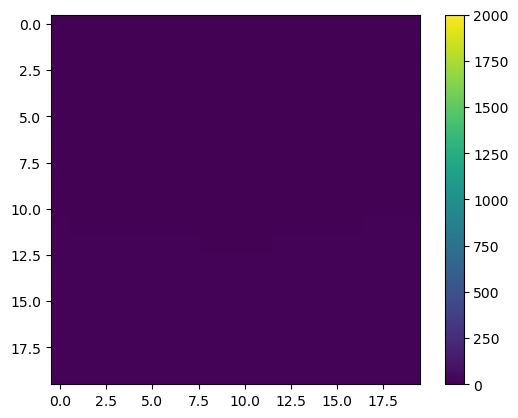

In [126]:
records = []

for i in range(1000):
    C_t = simulate_closed_boundary(C_t)
    records.append(C_t)

# with np.printoptions(precision=2,floatmode='fixed',linewidth=200):
#     print(C_t)

plt.imshow(C_t, vmin=0, vmax=2000)
plt.colorbar()
plt.show()


### Widget

In [127]:
def update(w = 1):
    fig = plt.figure(figsize = (10,7))
    y = records[w]
    plt.imshow(y, vmin=0, vmax=50)
    
interact(update, w = IntSlider(min=0, max = 999, step = 1, value = 0))

interactive(children=(IntSlider(value=0, description='w', max=999), Output()), _dom_classes=('widget-interact'…

<function __main__.update(w=1)>

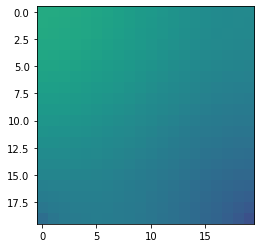

In [35]:
import matplotlib.animation as animation


frames = []
fig = plt.figure()
for i in records:
    frames.append([plt.imshow(i, vmin=0, vmax=10, animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)

ani.save("/Users/hannessigner/Desktop/test.gif")